In [ ]:
### Install Packages
import tensorflow as tf
import os
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np
import math
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
## Avoid OOM Errors by setting GPU memory consumtion growth
"""This approach helps to avoid OOM errors by allowing TensorFlow to dynamically allocate GPU memory as needed,
 which is particularly useful in environments with limited GPU resources, like Google Colab. This code is designed to
 manage GPU memory usage in TensorFlow when running on a GPU-enabled environment like Google Colab. Let's break it down:"""


gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

  """This block of code is essential for setting up your data access in Google Colab.
By mounting Google Drive, setting the data directory, and listing its contents, you prepare the environment to work with your image classification dataset.
This setup ensures that your data is correctly accessed from Google Drive, enabling smooth progress in your project."""

from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/colab_notebook/ImageClassification/data'
os.listdir(data_dir)

# List of acceptable image formats
image_exts = ['jpeg', 'jpg', 'bmp', 'png', 'gif']

Mounted at /content/drive


In [ ]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import logging
from concurrent.futures import ThreadPoolExecutor

# Setup logging instead of printing
logging.basicConfig(filename='image_validation.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Valid image extensions
image_exts = ['jpeg', 'jpg', 'bmp', 'png', 'gif']

def check_image(image_path):
    """
    Function to check if an image is valid. If invalid, it removes the image.
    Logs any issues encountered.
    """
    try:
        # Attempt to read the image
        img = cv2.imread(image_path)

        # Check the image file format using imghdr
        tip = imghdr.what(image_path)

        # If the format is not in the valid list, remove the file and log it
        if tip not in image_exts:
            logging.warning(f'Invalid image format for {image_path}. Removing file.')
            os.remove(image_path)

        # Check if the image was read properly by OpenCV
        if img is None:
            logging.warning(f'Image could not be read by OpenCV {image_path}. Removing file.')
            os.remove(image_path)

    except FileNotFoundError:
        logging.error(f'File not found: {image_path}')
    except OSError as e:
        logging.error(f'Error reading file {image_path}: {e}')
    except Exception as e:
        logging.error(f'An unexpected error occurred with {image_path}: {e}')

def process_directory(data_dir):
    """
    Function to process each class directory in parallel, checking and removing invalid images.
    Uses ThreadPoolExecutor to parallelize the process.
    """
    class_dirs = [os.path.join(data_dir, class_dir) for class_dir in os.listdir(data_dir)]
    images_to_check = []

    for class_dir in class_dirs:
        if os.path.isdir(class_dir):  # Only process directories (class folders)
            images_to_check.extend([os.path.join(class_dir, image) for image in os.listdir(class_dir)])

    # Use ThreadPoolExecutor to parallelize the image checking process
    with ThreadPoolExecutor() as executor:
        executor.map(check_image, images_to_check)

# Example usage
# Replace with your dataset directory path
process_directory(data_dir)

In [ ]:
"""tf.keras.utils.image_dataset_from_directory:
What it does: This function is a utility provided by TensorFlow's Keras API to load images from a directory structure and automatically label them based on the folder names. It creates a tf.data.Dataset object that is ready to be used in training deep learning models.
Key Features:
Automatic Labeling: The function automatically labels images based on the directory structure.
Images in the happy folder will be labeled with one class, and images in the sad folder will be labeled with another class.
Data Preparation: The function handles important preprocessing tasks such as resizing the images to a uniform size, shuffling the data, batching it, and potentially splitting it into training and validation sets.
"""
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/colab_notebook/ImageClassification/data')


Found 6442 files belonging to 2 classes.


In [ ]:
"""•	for images, labels in data.take(1):: This line extracts a single batch of images and their corresponding labels from the dataset.
•	print(images.shape): Prints the shape of the images tensor, which tells you how many images are in the batch and their dimensions.
•	print(labels.shape): Prints the shape of the labels tensor, which confirms the number of labels corresponding to the images.
•	print(labels): Prints the actual labels for the images in the batch, allowing you to see which class each image belongs to."""

for images,labels in data.take(1):
  print(images.shape)
  print(labels.shape)
  print(labels)

(32, 256, 256, 3)
(32,)
tf.Tensor([0 0 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0], shape=(32,), dtype=int32)


In [ ]:
#example of showing images in one of the batches (take1)
plt.figure(figsize=(10,10))
for images,labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype(int))
    plt.title(f'Label: {labels[i].numpy()}')
    plt.axis("on")

plt.show()

In [ ]:
# In order to find the number of batches that were created, it can be done by using one of the methods:

# Method 1: Count the number of batches by iterating through the dataset
num_batches = 0
for batch in data:
    num_batches += 1
print(f'Total number of batches: {num_batches}')

# Method 2: Using cardinality() to get the number of batches
#num_batches = tf.data.experimental.cardinality(data).numpy()
#print(f'Total number of batches: {num_batches}')

# Method 3: Calculating manually (if you know the total number of images)
#total_images = len(data.file_paths)  # If the dataset provides this attribute
#batch_size = 32  # Or whatever batch size you used
#num_batches = math.ceil(total_images / batch_size)
#print(f'Total number of batches: {num_batches}')

In [ ]:
#converting data from tensor to numpy.
data_iterator = data.as_numpy_iterator()
#create a batch
batch = data_iterator.next()

In [ ]:
images, labels = next(data_iterator)
print(f'Shape of Image: {images.shape}')

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
"""Normalize the Data: The code normalizes the pixel values of images in your dataset from the original range of 0 to 255
to a new range of 0 to 1, which is a common preprocessing step in machine learning.
Code Execution: The data.map(lambda x, y: (x / 255, y)) function applies this normalization to every image in the dataset while leaving the labels unchanged.
Purpose: This normalization step is essential for improving the model's learning process and ensuring that the input data is
scaled appropriately for the model to handle."""

data = data.map(lambda x,y:(x/255,y))

The MAX Value of each image is 1.0
The MIN Value of each image is 0.0


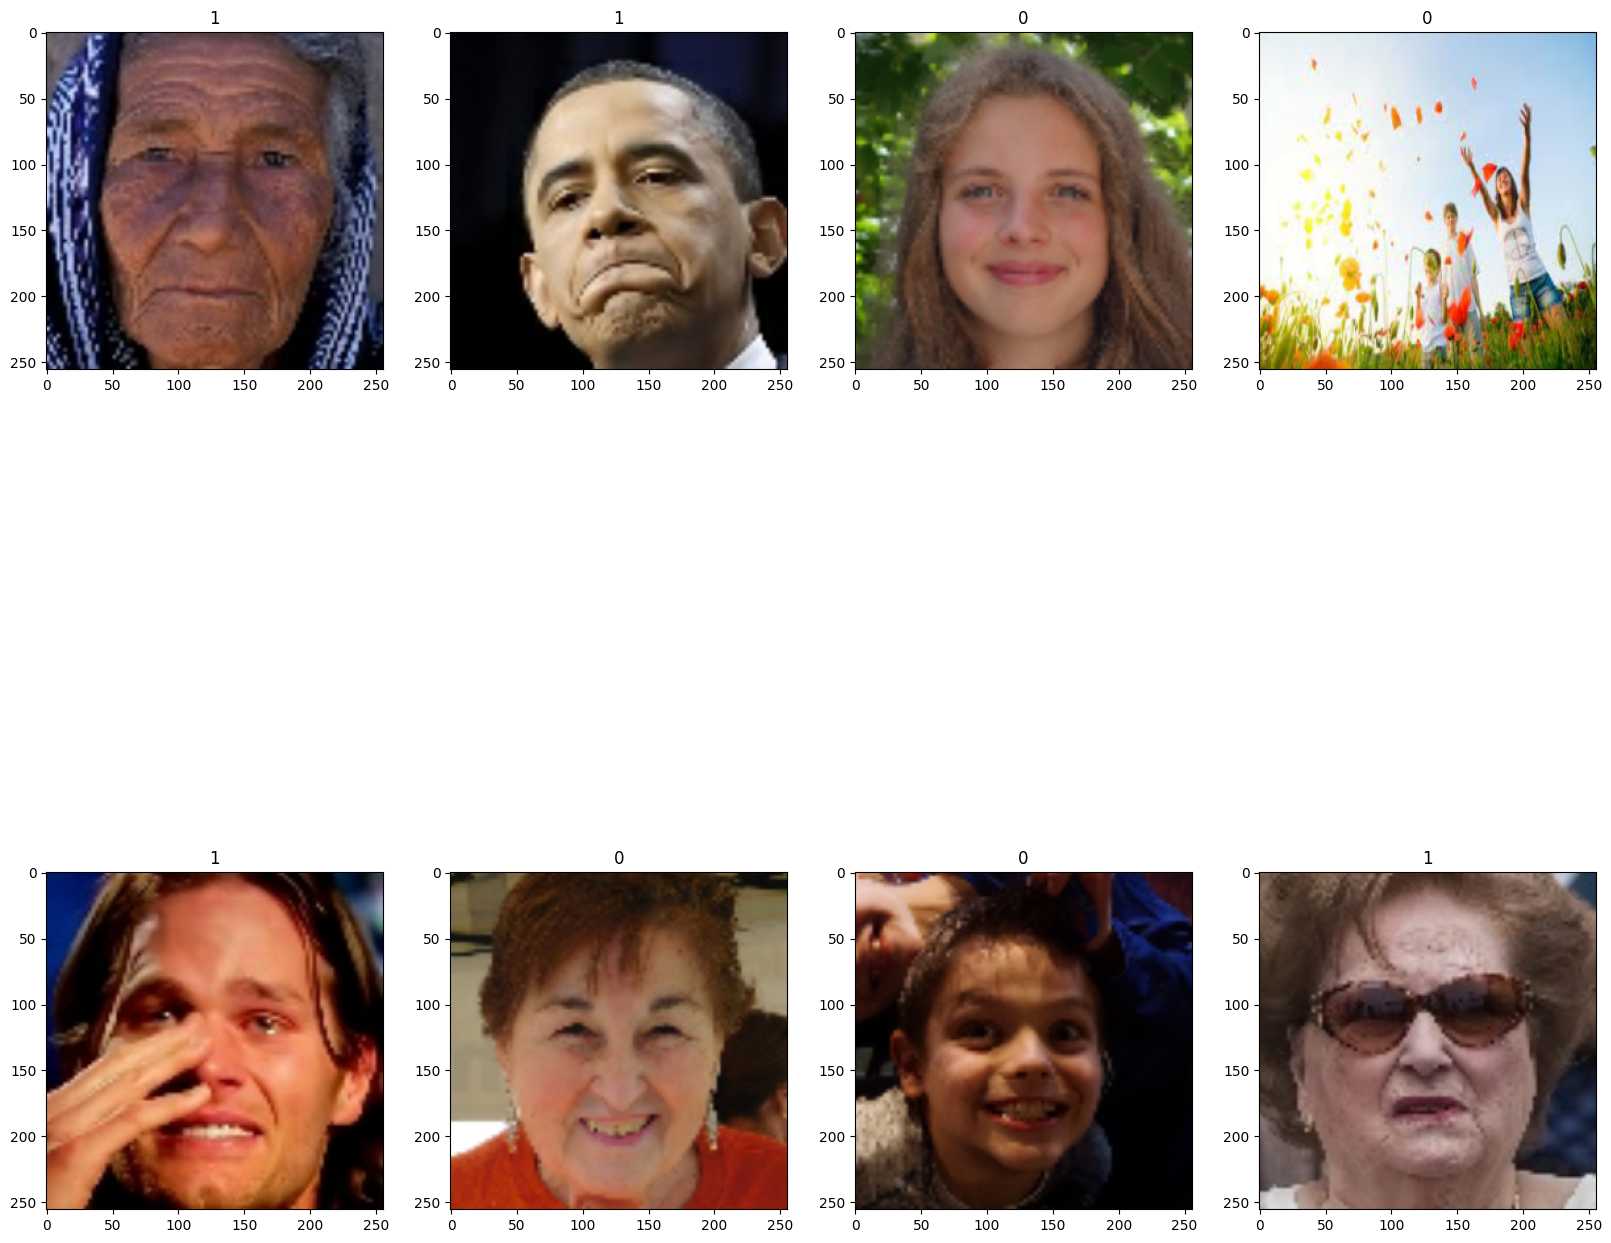

In [ ]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

print(f'The MAX Value of each image is {data.as_numpy_iterator().next()[0].max()}\nThe MIN Value of each image is {data.as_numpy_iterator().next()[0].min()}')

fig,ax = plt.subplots(nrows=2,ncols=4,figsize=(20,20))
for idx,img in enumerate(batch[0][:8]):
  ax = ax.ravel()
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

In [ ]:
"""
This code snippet is used to split a dataset into three parts: training, validation, and testing
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1"""

'\nThis code snippet is used to split a dataset into three parts: training, validation, and testing\ntrain_size = int(len(data)*.7)\nval_size = int(len(data)*.2)+1\ntest_size = int(len(data)*.1)+1'

In [ ]:
"""train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)"""

'train = data.take(train_size)\nval = data.skip(train_size).take(val_size)\ntest = data.skip(train_size+val_size).take(test_size)'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Gather all image file paths and their corresponding labels
image_paths = []
labels = []

# Loop through the directory and get the file paths and labels
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir,class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image_paths.append(img_path)
            labels.append(class_name)

# Convert to a pandas DataFrame
df = pd.DataFrame({
    'filename': image_paths,
    'label': labels
})

# 2. Split the data into train, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)  # 80% train, 20% test
train_df, val_df = train_test_split(train_df, test_size=0.15, stratify=train_df['label'], random_state=42)  # 15% of remaining for validation

# 3. Create ImageDataGenerators for train, validation, and test sets with normalization
datagen = ImageDataGenerator(
    rescale=1./255,            # Normalize pixel values to [0, 1]
    rotation_range=40,         # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,     # Randomly shift the width of the image by 20%
    height_shift_range=0.2,    # Randomly shift the height of the image by 20%
    shear_range=0.2,           # Shear transformation (slant the image)
    zoom_range=0.2,            # Random zoom on images
    horizontal_flip=True,      # Flip images horizontally
    fill_mode='nearest'        # Fill any gaps after transformation
)

# Training data generator
train_data = datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Validation data generator with normalization (but no augmentation)
val_data = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Test data generator with normalization
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='label',
    target_size=(256, 256),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Display the sizes
print(f'Training set size: {train_data.samples}')
print(f'Validation set size: {val_data.samples}')
print(f'Test set size: {test_data.samples}')


print(train_df['label'].value_counts())
print(val_df['label'].value_counts())
print(test_df['label'].value_counts())

Found 4380 validated image filenames belonging to 2 classes.
Found 773 validated image filenames belonging to 2 classes.
Found 1289 validated image filenames belonging to 2 classes.
Training set size: 4380
Validation set size: 773
Test set size: 1289
label
happy    2190
sad      2190
Name: count, dtype: int64
label
sad      387
happy    386
Name: count, dtype: int64
label
sad      645
happy    644
Name: count, dtype: int64


In [ ]:
"""•	train: The first portion of the dataset, consisting of train_size samples, used to train the model.
   •	val: The middle portion of the dataset, consisting of val_size samples after the training set, used for validating the model during training.
   •	test: The last portion of the dataset, consisting of test_size samples after both the training and validation sets, used for testing the model's
   final performance.

   train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)"""

"•\ttrain: The first portion of the dataset, consisting of train_size samples, used to train the model.\n   •\tval: The middle portion of the dataset, consisting of val_size samples after the training set, used for validating the model during training.\n   •\ttest: The last portion of the dataset, consisting of test_size samples after both the training and validation sets, used for testing the model's\n   final performance.\n\n   train = data.take(train_size)\nval = data.skip(train_size).take(val_size)\ntest = data.skip(train_size+val_size).take(test_size)"

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

In [47]:
from ssl import ALERT_DESCRIPTION_BAD_CERTIFICATE_HASH_VALUE
"""This sequence of layers defines a Convolutional Neural Network (CNN) designed for binary classification.
It starts with several convolutional layers for feature extraction, followed by max-pooling layers to downsample the feature maps,
a flattening layer to prepare the data for fully connected layers, and ends with a dense layer that outputs the final prediction.
Each layer has a specific role, contributing to the model's ability to learn and make accurate predictions.
"""
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Regularization
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
"""model.compile(): This method sets up the model with the necessary configurations for training.
'adam': Specifies the Adam optimizer, which adapts learning rates and is generally effective across a wide range of problems.
loss=tf.losses.BinaryCrossentropy(): Sets the loss function to binary crossentropy, ideal for binary classification tasks to
measure how well the model’s predictions match the actual labels.
metrics=['accuracy']: Uses accuracy as the performance metric, which provides a straightforward measure of how many predictions the model gets right.
This configuration prepares the model to be trained effectively on a binary classification task, where the model will learn by minimizing the binary crossentropy
loss and its performance will be monitored using accuracy."""

model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])


In [ ]:
"""The output you provided is the summary of a Convolutional Neural Network (CNN) model generated by the model.summary() function in Keras.
This summary provides detailed information about each layer in the model, including the type of layer,
the shape of the output, and the number of parameters (weights) involved."""

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      58,982,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,076,673 (225.36 MB)

 Trainable params: 59,076,673 (225.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
"""
# EarlyStopping will stop the training if the validation loss does not improve for 3 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True)

# Train the model with early stopping
hist = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stopping]
)


"""
hist = model.fit(train_data, epochs=20, validation_data=val_data, callbacks=[tensorboard_callback])

In [ ]:
hist.history

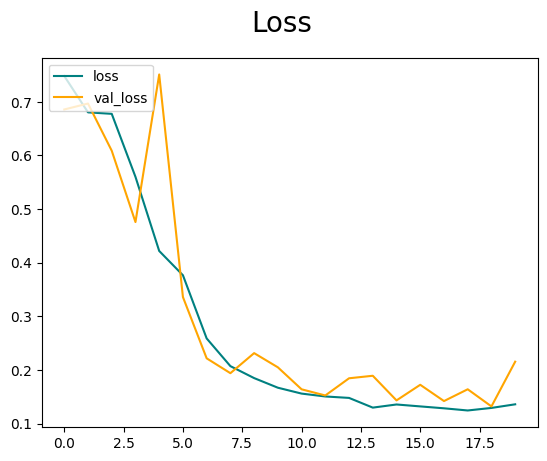

In [44]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

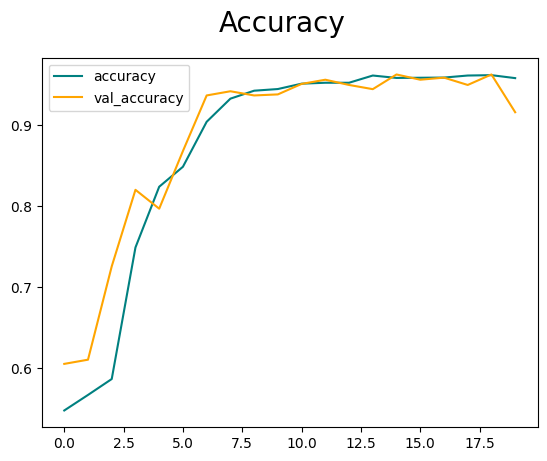

In [45]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [46]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [34]:
"""for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)"""

'for batch in test.as_numpy_iterator():\n    X, y = batch\n    yhat = model.predict(X)\n    pre.update_state(y, yhat)\n    re.update_state(y, yhat)\n    acc.update_state(y, yhat)'

In [35]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy: {acc.result().numpy()}')


Precision:0.9769141674041748, Recall:0.8511689901351929, Accuracy: 0.9154457449913025


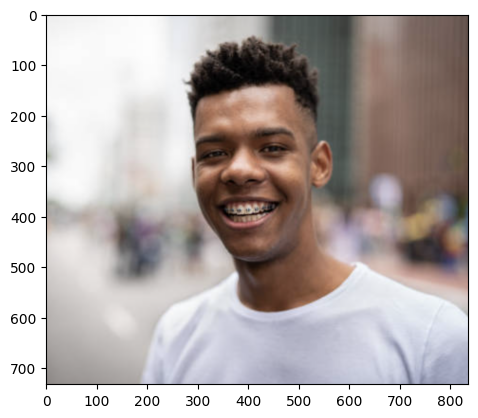

In [40]:
import cv2
directory_path = '/content/drive/MyDrive/colab_notebook/ImageClassification/test_image'
new_image = os.path.join(directory_path,'happy2.png')

img = cv2.imread(new_image)
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

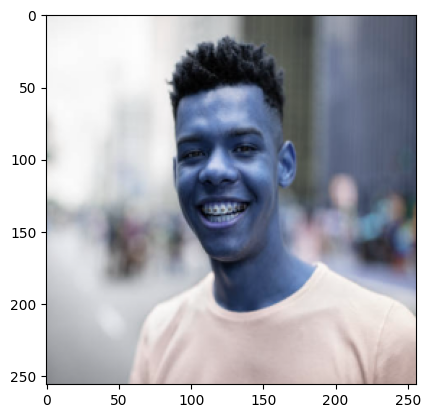

In [41]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [42]:
np.expand_dims(resize,0)
yhat = model.predict(np.expand_dims(resize/255,0))
yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


array([[0.38586855]], dtype=float32)

In [43]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy
